# Notes 2 Vect

The goal of this Notebook is to figure out if we can create an embedding for each specific note.

In [1]:
#Preamble
%matplotlib inline
import sys
import numpy as np
from matplotlib import pyplot
import pandas as pd
import gensim
import logging as log
import csv
import pickle as pkl
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize

# Logging config
log.basicConfig(format='%(levelname)s : %(message)s', level=log.INFO)

# Seeds:
np.random.seed(42)

Read in the .csv notes data:

In [2]:
def load_notes():
    "Load in the notes from the .csv file"
    global notes

    file_name = 'data/disch_full.csv'
    
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader) # skip the header
#         notes = [row[3] for row in csv_reader]
        notes = [row for row in csv_reader]
    
    log.info("Done loading notes with length {}".format(len(notes)))

In [ ]:
def load_pickle_file(name):
    "Get the value from the pickle file and set it as the variable value"
    with open("data/{}.pkl".format(name), "rb") as pickle_file:        
        globals()[name] = np.array(pkl.load(pickle_file))

In [ ]:
load_pickle_file("tagged_notes")

In [3]:
load_notes()

INFO : Done loading notes with length 59652


In [5]:
notes[0:2]

[['22532',
  '167853',
  '',
  'admission date discharge date service addendum radiologic studies radiologic studies also included a chest ct which confirmed cavitary lesions in the left lung apex consistent with infectious process tuberculosis this also moderate sized left pleural effusion head ct head ct showed no intracranial hemorrhage or mass effect but old infarction consistent with past medical history abdominal ct abdominal ct showed lesions of t10 and sacrum most likely secondary to osteoporosis these can be followed by repeat imaging as an outpatient first name8 namepattern2 first name4 namepattern1 last name namepattern1 m d md number dictated by hospital medquist36 d t job job number'],
 ['13702',
  '107527',
  '',
  'admission date discharge date date of birth sex f service micu and then to doctor last name medicine history of present illness this is an year old female with a history of emphysema not on home o2 who presents with three days of shortness of breath thought by

##  Vectors

Now that all the notes are in the `notes` variable, we can begin training for our vectors. Reference material: [Article 1](https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5) and [article 2](https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.TaggedDocument).

In [ ]:
tagged_notes = [gensim.models.doc2vec.TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(notes)]

In [ ]:
def save_pickle_file(name, data):
    "Save out the data as a pickle file"
    with open("data/{}.pkl".format(name), "wb") as pickle_file:
        pkl.dump(data, pickle_file)

In [ ]:
#save_pickle_file("tagged_notes", tagged_notes)

In [ ]:
def make_model(max_epochs = 5, vec_size = 100, alpha = 0.025):
    "Make the model for notes 2 vect"
    global model
    
    model = gensim.models.doc2vec.Doc2Vec(vector_size=vec_size,
                                            alpha=alpha, 
                                            min_alpha=0.00025,
                                            min_count=1,
                                            dm=1,
                                            workers=2
                                         )
    model.build_vocab(tagged_notes)
    
    for epoch in range(max_epochs):
        log.info('iteration {0}'.format(epoch))
        model.train(tagged_notes,
                    total_examples=model.corpus_count,
                    epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

    model.save("models/{}_{}_notes2vect.w2v".format(vec_size, max_epochs))
    log.info("Model Saved")

In [ ]:
make_model(vec_size = 200)

## Testing

Now that the new embedding has been saved, we can go ahead and test it out. The best way test out if the embedding is useful is to try and and see what it tells us as similar notes.

In [ ]:
def check_model():
    "Check to see if the model is working properly"
    check_model= gensim.models.doc2vec.Doc2Vec.load("models/100_10_notes2vect.w2v")
    test_data = word_tokenize("Patient was showing suicidal ideation.".lower())
    v1 = check_model.infer_vector(test_data)
    
    # Vector for our test_data sentence:
    print("V1_infer", v1)
    
    # List of similar documents:
    similar_doc = check_model.docvecs.most_similar('1')
    print(similar_doc)

    # Find vector of doc in training data using tags or in other words, 
    print(check_model.docvecs['1'])

In [ ]:
check_model()

In [ ]:
check_model= gensim.models.doc2vec.Doc2Vec.load("models/100_10_notes2vect.w2v")

In [ ]:
len(check_model.docvecs)

In [ ]:
len(notes)

# Plots

Now that we have the suicide class values in `suicide_class.csv` file, we can match it with the notes csv file (specifically the field called "subject_id").

In [6]:
def load_embedding(filename):
    "Load the embedding for a given filename"
    return gensim.models.doc2vec.Doc2Vec.load(filename)

In [7]:
embedding = load_embedding("models/200_5_notes2vect.w2v")

INFO : loading Doc2Vec object from models/200_5_notes2vect.w2v
INFO : loading vocabulary recursively from models/200_5_notes2vect.w2v.vocabulary.* with mmap=None
INFO : loading trainables recursively from models/200_5_notes2vect.w2v.trainables.* with mmap=None
INFO : loading syn1neg from models/200_5_notes2vect.w2v.trainables.syn1neg.npy with mmap=None
INFO : loading wv recursively from models/200_5_notes2vect.w2v.wv.* with mmap=None
INFO : loading vectors from models/200_5_notes2vect.w2v.wv.vectors.npy with mmap=None
INFO : loading docvecs recursively from models/200_5_notes2vect.w2v.docvecs.* with mmap=None
INFO : loading vectors_docs from models/200_5_notes2vect.w2v.docvecs.vectors_docs.npy with mmap=None
INFO : loaded models/200_5_notes2vect.w2v


In [8]:
def load_suicide_csv():
    "Load the suicide csv dataset"
    global suicide_subject_ids

    file_name = 'data/suicide_class.csv'
    
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader) # skip the header
        suicide_subject_ids = [int(row[0]) for row in csv_reader]

In [9]:
load_suicide_csv()

In [10]:
suicide_subject_ids[0:4]

[71, 119, 449, 468]

In [12]:
len(notes)

59652

In [13]:
df = pd.DataFrame(notes)
df.columns = ["SUBJECT_ID","HADM_ID","CHARTTIME","TEXT"]

In [14]:
found_id = lambda id: id in suicide_subject_ids

In [15]:
df['VECTORS'] = [[1.1, 2.2]]*len(df)
df['SUICIDE'] = [False]*len(df)

In [16]:
def func(row):
    return found_id(int(row.SUBJECT_ID))

def sub_to_int(row):
    return int(row.SUBJECT_ID)

def hadm_to_int(row):
    return int(row.HADM_ID)

def add_vectors(row):
    return embedding.docvecs[str(row.name)]

In [17]:
df.SUICIDE = df.apply(func,axis=1)
df.SUBJECT_ID = df.apply(sub_to_int, axis=1)
df.HADM_ID = df.apply(hadm_to_int, axis=1)
df.VECTORS = df.apply(add_vectors, axis=1)

In [18]:
df.SUICIDE.unique()

array([False,  True])

In [19]:
df.SUICIDE.value_counts()

False    58736
True       916
Name: SUICIDE, dtype: int64

In [20]:
df.head()

,SUBJECT_ID,HADM_ID,CHARTTIME,TEXT,VECTORS,SUICIDE
0,22532,167853,,admission date discharge date service addendum...,"[0.39852864, -0.1671015, 0.7521763, 0.54836917...",False
1,13702,107527,,admission date discharge date date of birth se...,"[0.0020026737, 0.10612658, 1.5018982, 0.843314...",False
2,13702,167118,,admission date discharge date service cardioth...,"[0.08271298, 0.41421026, 0.10357042, 0.0394304...",False
3,13702,196489,,admission date discharge date service medicine...,"[-1.1403258, 0.18988298, 0.29465637, 1.0322447...",False
4,26880,135453,,admission date discharge date date of birth se...,"[0.3301744, -1.3839103, -0.121851526, 0.053400...",False


In [21]:
print("Number of suicide notes is {0:.3f}%".format((916/58736)*100))

Number of suicide notes is 1.560%


Stratified sampling

In [22]:
suicide_df = df[df['SUICIDE'] == True]
not_suicide_df = df[df['SUICIDE'] == False]

In [54]:
suicide_df.loc[suicide_df['SUBJECT_ID'] == 12080]

,SUBJECT_ID,HADM_ID,CHARTTIME,TEXT,VECTORS,SUICIDE
33908,12080,182794,,admission date discharge date date of birth se...,"[1.838024, 0.039114416, 0.12507683, 1.3202151,...",True


### Getting the T-SNE Plot:

Now that all the data is in the shape that we need, we can perform the T-SNE dimensionality reduction to see where the 916 suicide notes are plotted given their vectors.

In [43]:
def tsne_model(model, data_frame, model_pkl, new_values_pkl, perplexity=40):
    "Create the t-SNE model"
    
    tokens = []
    
    for index, row in data_frame.iterrows():
        tokens.append(row.VECTORS)
    
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    # Save the model
    with open("models/{}.pickle".format(model_pkl), "wb") as pickle_file:
        pkl.dump(tsne_model, pickle_file)
        
    # Save the new_values
    with open("models/{}.pickle".format(new_values_pkl), "wb") as pickle_file:
        pkl.dump(new_values, pickle_file)
    
    return new_values

In [ ]:
emb_2d_values = tsne_model(embedding, 
                           suicide_df, 
                           model_pkl="tsne_note_to_vect_pos_model", 
                           new_values_pkl="tsne_note_to_vect_pos_values")

In [44]:
def tsne_plot(vectors, data_frame, title, filename="no-name-plot", labels_show=True, save=False):
    "Creates the t-SNE plot"
    global vectors_1_clean, vectors_2_clean
    labels = []
    
    outliers = [25503,49938,20382]
    outlier_id = []

    i = 0
    for index, row in data_frame.iterrows():
        if index not in outliers:
            labels.append(index)
        else:
            outlier_id.append(i)
        i = i + 1

    vectors_1_clean = []
#     vectors_2_clean = []
    x = []
    y = []
    for i, value in enumerate(vectors):
        if i not in outlier_id:
            x.append(value[0])
            y.append(value[1])
#             vectors_2_clean.append([value[0], value[1]])
            vectors_1_clean.append([value[0], value[1]])
            
    vectors_2_clean = np.array(vectors_2_clean)
        
    plot = pyplot.figure(figsize=(16, 16))
    pyplot.title(title)
    for i in range(len(x)):
        pyplot.scatter(x[i],y[i])
        if labels_show:
            pyplot.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
            
    pyplot.show()
    # Save a .png of the plot
    if save:
        plot.savefig("output/{}".format(filename))

In [ ]:
tsne_plot(vectors=emb_2d_values, 
          data_frame=suicide_df, 
          title="T-SNE for Positive Class Note2Vect", 
          labels_show=True,
          filename="tsne_note_to_vect_pos_plot.png",
         )

In [45]:
# randomly sample 900 points from the negative class of notes:
negative_random_notes = not_suicide_df.sample(n=900)

In [ ]:
# Create the T-SNE for the negative notes:
emb_2d_values_neg = tsne_model(embedding, 
                               negative_random_notes,
                               model_pkl="tsne_note_to_vect_neg_model", 
                               new_values_pkl="tsne_note_to_vect_neg_values")

In [ ]:
tsne_plot(vectors=emb_2d_values_neg, 
          data_frame=negative_random_notes, 
          title="T-SNE for Negative Class Note2Vect", 
          labels_show=True,
          filename="tsne_note_to_vect_neg_no_labels_plot.png"
         )

In [46]:
joint_df = pd.concat([suicide_df,negative_random_notes]) # first 916 are suicide, next 900 are not suicide

In [47]:
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1816 entries, 33 to 12499
Data columns (total 6 columns):
SUBJECT_ID    1816 non-null int64
HADM_ID       1816 non-null int64
CHARTTIME     1816 non-null object
TEXT          1816 non-null object
VECTORS       1816 non-null object
SUICIDE       1816 non-null bool
dtypes: bool(1), int64(2), object(3)
memory usage: 86.9+ KB


In [48]:
# Get the joint tsne for all the notes combined:
joint_tsne_values = tsne_model(embedding, 
                                joint_df, 
                                model_pkl="tsne_note_to_vect_joint_model", 
                                new_values_pkl="tsne_note_to_vect_joint_values")

In [49]:
# Add the XY column
joint_df['XY'] = [[x, y] for x,y in joint_tsne_values]

In [58]:
joint_df.head()

,SUBJECT_ID,HADM_ID,CHARTTIME,TEXT,VECTORS,SUICIDE,XY
33,19183,145164,,admission date discharge date date of birth se...,"[0.5490569, -1.0463872, 2.3742604, 3.8042455, ...",True,"[0.29713508, -2.0225675]"
65,76874,113329,,admission date discharge date date of birth se...,"[-0.24526086, -0.73347014, 0.998312, 1.939286,...",True,"[4.0805173, -0.31190935]"
201,42753,121343,,admission date discharge date date of birth se...,"[-0.37974367, -1.4513984, 0.069716275, -0.7680...",True,"[-0.37074783, -0.62927455]"
232,30565,146707,,admission date discharge date date of birth se...,"[0.037499756, 0.71773505, 1.3312695, -0.527831...",True,"[2.4108996, -0.84657633]"
233,30565,105393,,admission date discharge date date of birth se...,"[-0.072421744, -0.02542495, 1.4349209, 0.40642...",True,"[1.846985, -0.18512975]"


In [92]:
def tsne_plot_mixed(joint_df, title, filename="tsne_note_to_vect_plot", save=False, show_labels=False):
    "Creates the t-SNE plot which has both the clases on it"
        
    plot = pyplot.figure(figsize=(16, 10))
    pyplot.title(title, fontsize=24)
    
    outliers = [19410,14282,26803,45509,11818,99293,14912]
    outlier_id = []

    i = 0
    labels = []
    data = []
    types = []
    for row in joint_df.values:
        if row[0] not in outliers:
            labels.append(row[0])
            data.append(row[6])
            types.append(row[5])
        else:
            outlier_id.append(i)
        i = i + 1
        
    for index, item in enumerate(data):
        if types[index]:
            pyplot.scatter([item[0]], [item[1]], c='red', label='Suicide')
        else:
            pyplot.scatter([item[0]], [item[1]], c='blue', label='Not Suicide')
        if show_labels:
            pyplot.annotate(labels[index],
                     xy=(item[0], item[1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
            
    # Get the centroids:
    data = np.array(data)
    mean_1 = [data[:905,0].mean(), data[:905,1].mean()]
    mean_2 = [data[906:,0].mean(), data[906:,1].mean()]
    
    pyplot.scatter([mean_1[0]], [mean_1[1]], c='maroon', s=22**2)
    pyplot.scatter([mean_2[0]], [mean_2[1]], c='cyan', s=22**2)
    
#     pyplot.legend(loc=4, fontsize = 'xx-large')
    pyplot.show()
    # Save a .png of the plot
    if save:
        plot.savefig("output/{}.png".format(filename))

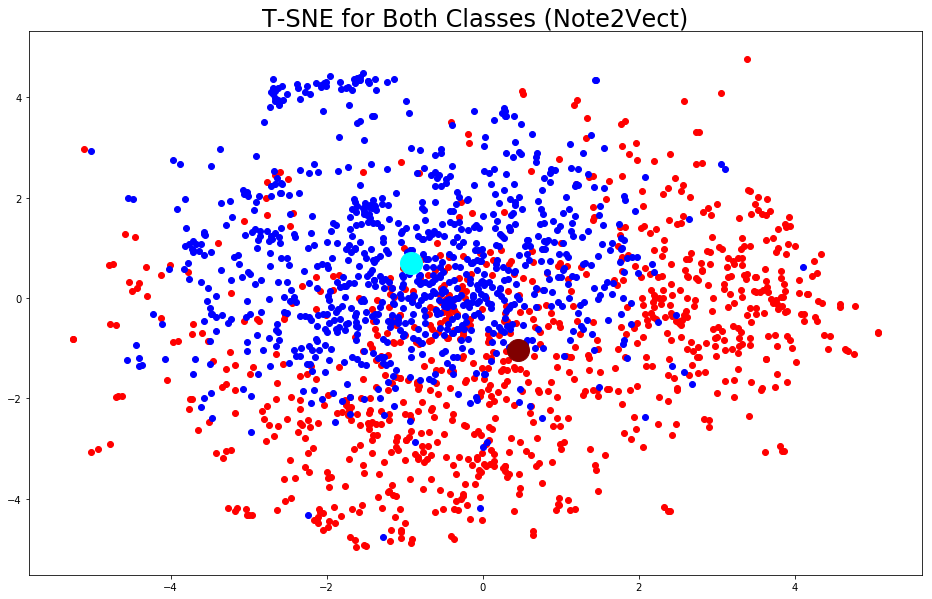

In [93]:
tsne_plot_mixed(joint_df=joint_df, 
                title="T-SNE for Both Classes (Note2Vect)",
                show_labels=False,
                save=False,
                filename="tsne_note_to_vect_centroid_plot"
               )